In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读入图片并显示

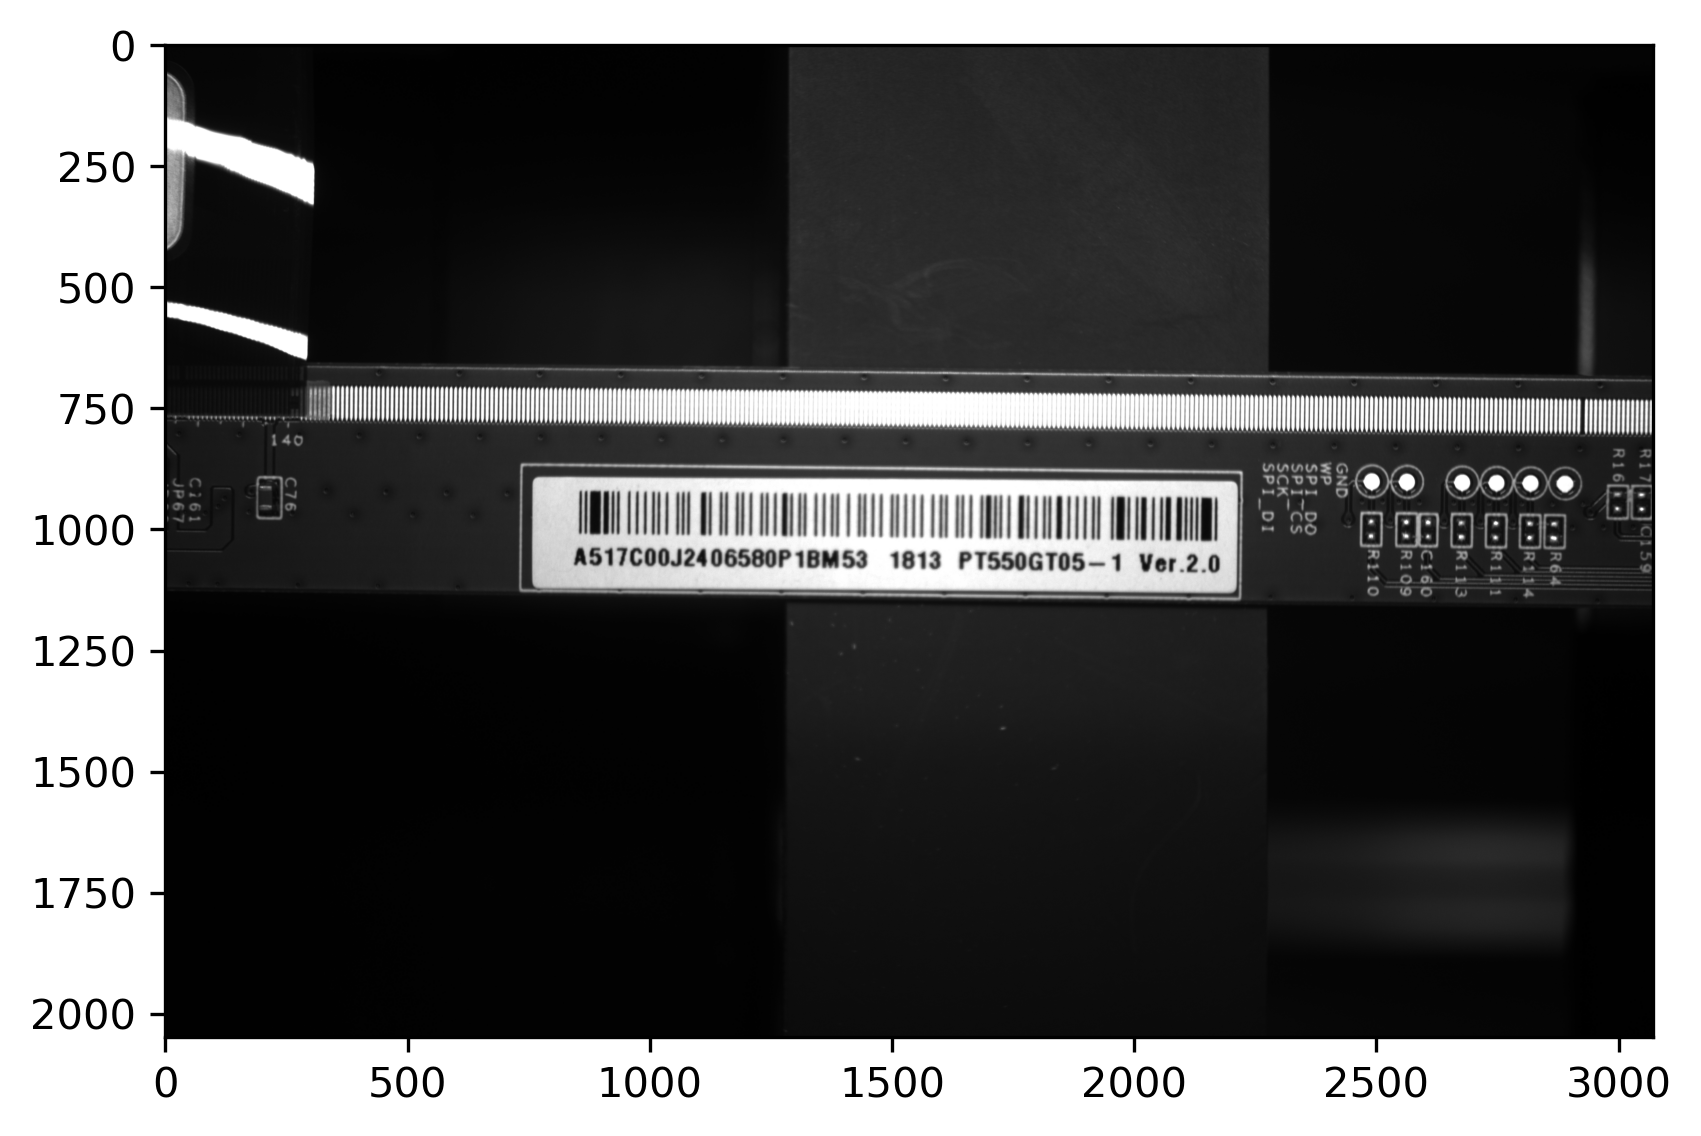

In [29]:
file = r"D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Factory\16.png"
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
plt.show()
# plt.subplot(2, 1, 1)
# plt.xticks([])
# plt.yticks([])
# plt.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
# plt.subplot(2, 1, 2)
# plt.hist(image_source.ravel(), 256, [0, 256], color='r')
# plt.xlim([0, 256])
# plt.xlabel('Gray Level')
# plt.ylabel('Number of Pixels')
# plt.title('Original Histogram')
# plt.show()

# 图像降采样

(683, 1024, 3)


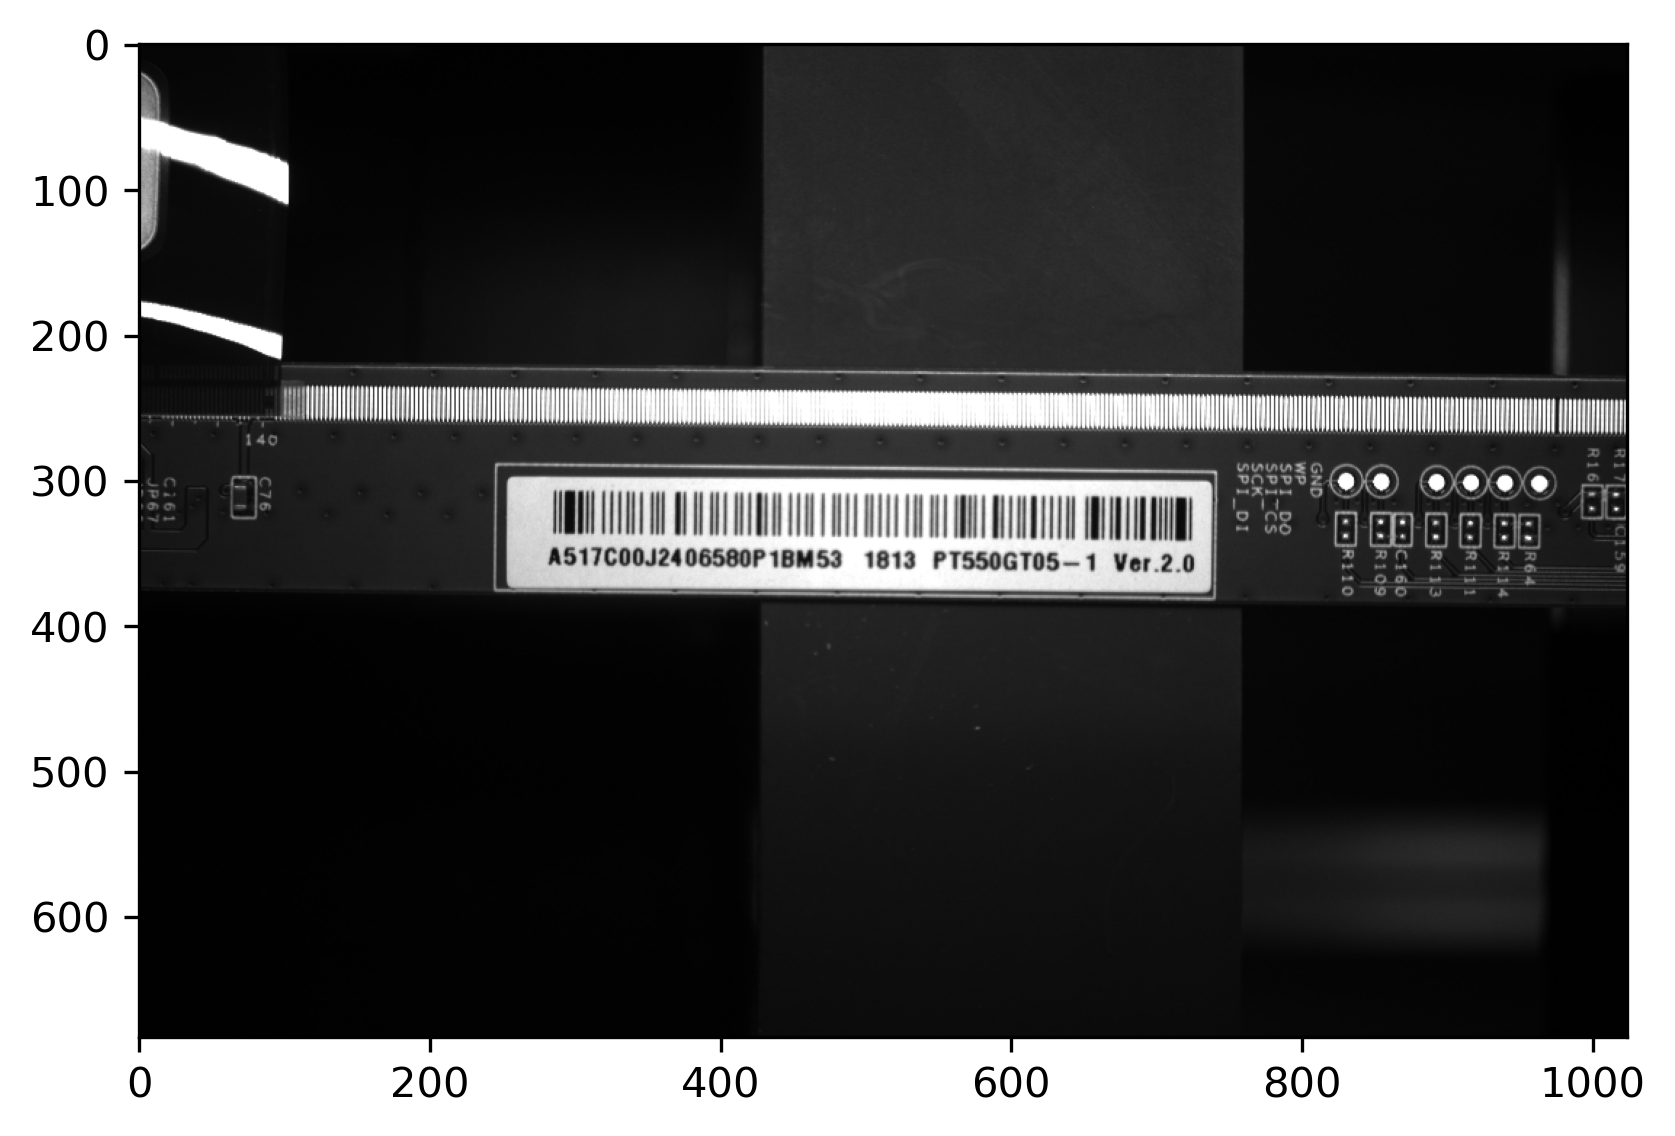

In [30]:
from tools.ImageOperate import downsample_with_edge_preservation

image_pydown = downsample_with_edge_preservation(image_source)
image_pydown_s = image_pydown

print(image_pydown_s.shape)

plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2RGB))
plt.show()

# 掩膜锐化

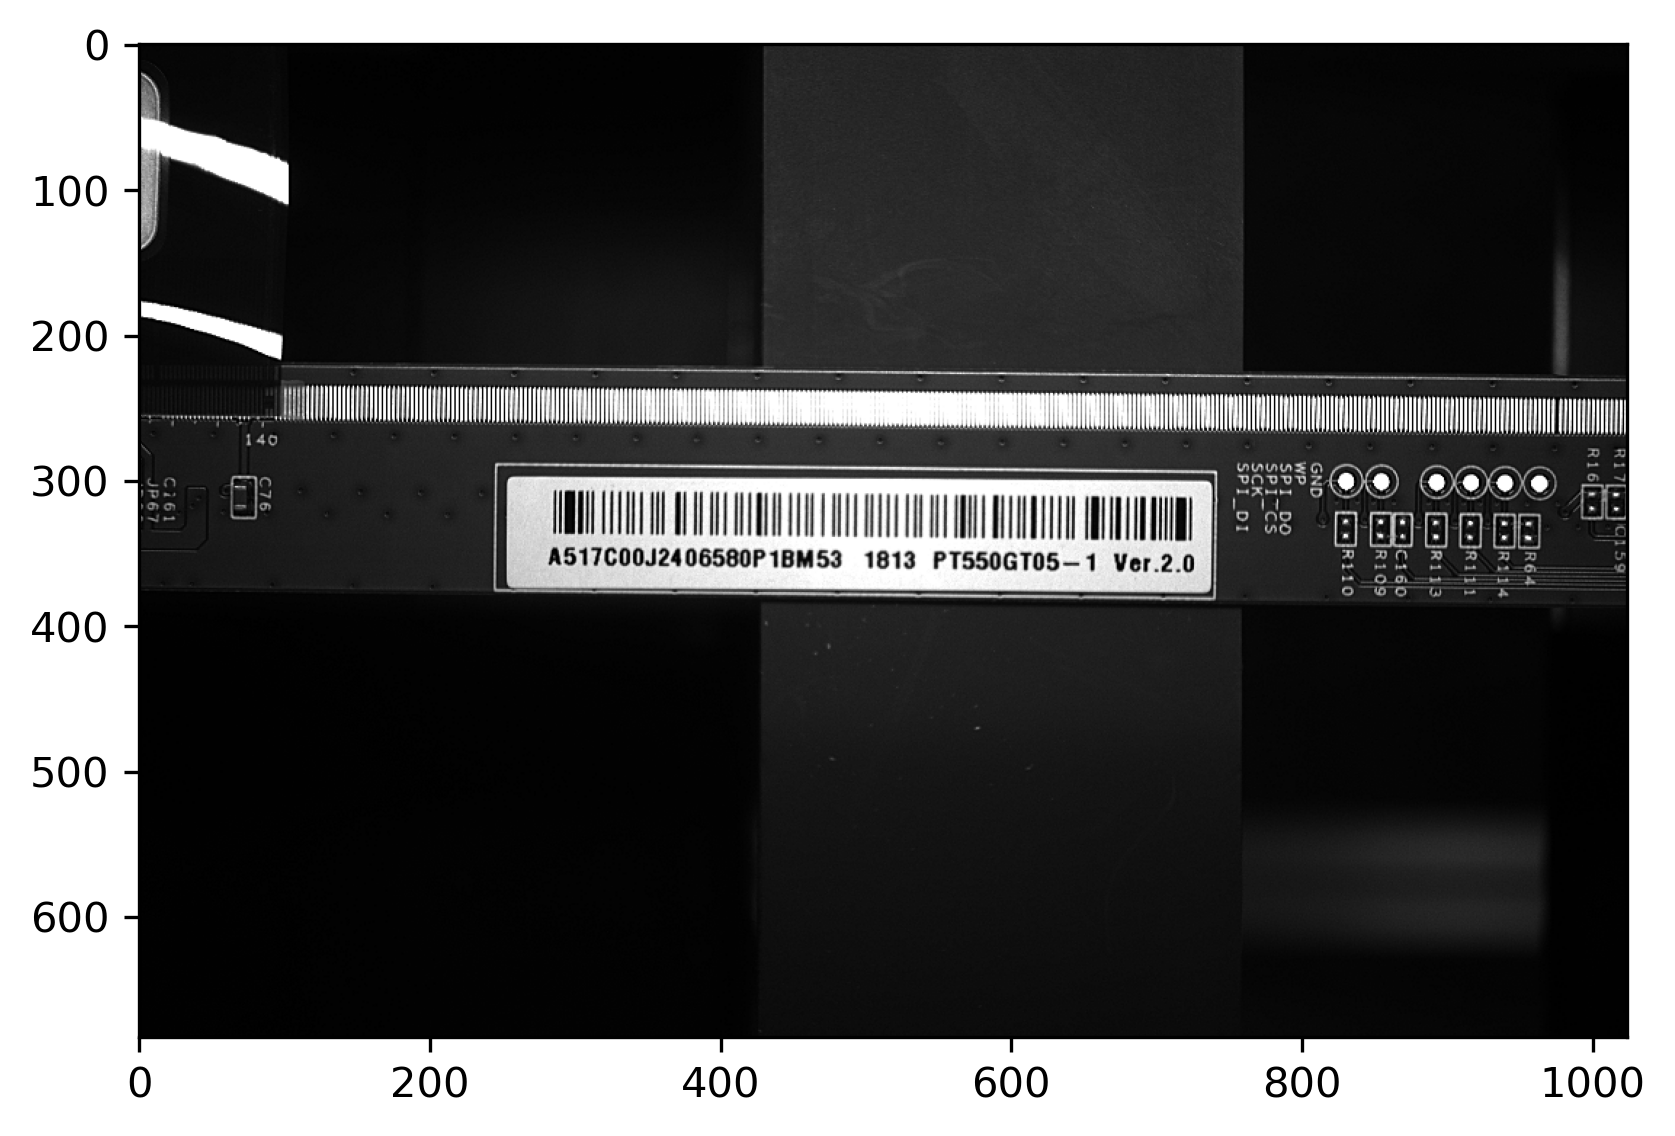

In [31]:
# 高斯模糊
blurred1 = cv2.GaussianBlur(image_pydown_s, (5, 5), 0, cv2.CV_64F)
res1 = image_pydown_s.astype(np.float64) - blurred1

# 增强后的图像
image_pydown_s = image_pydown_s + res1
image_pydown_s = np.clip(image_pydown_s, 0, 255).astype(np.uint8)
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2RGB))
plt.show()

# 去除异常亮块

## 阈值分割

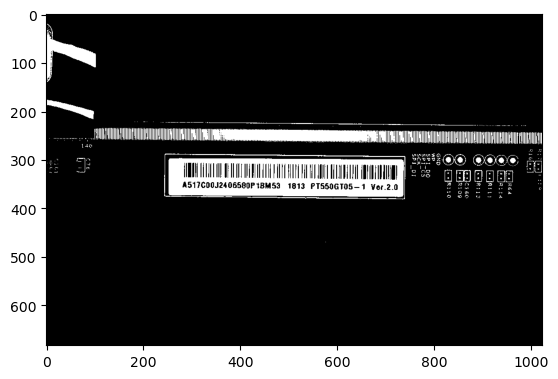

In [32]:
image_gray = cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2GRAY)
ret, image_threshold = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(image_threshold, 'gray')
plt.show()

## 直线检测

area_threshold:10490


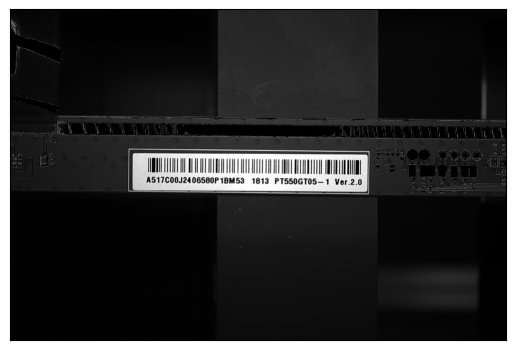

In [33]:
area_threshold = int(image_gray.shape[0] * image_gray.shape[1] * 0.015)
print("area_threshold:{}".format(area_threshold))
# kernel = np.ones((3, 3), np.uint8)
# closing = cv2.morphologyEx(image_threshold, cv2.MORPH_CLOSE, kernel)  # 闭运算

contours1, hierarchy1 = cv2.findContours(image_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

lsd = cv2.createLineSegmentDetector()
lines_list1 = []
contour_list = []
contour_list_line = []
for contour1 in contours1:
	x, y, w, h = cv2.boundingRect(contour1)
	if cv2.contourArea(contour1) > area_threshold:
		image_gray_part = image_gray[y:y + h, x:x + w]
		ret1, image_threshold1 = cv2.threshold(image_gray_part, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
		# detect lines1
		lines1, width, prec, nfa = lsd.detect(image_threshold1)
		if lines1 is not None:
			lines_list1.append(lines1)
			contour_list.append(contour1)
	else:
		cv2.drawContours(image_gray, [contour1], -1, 0, cv2.FILLED)
# 将列表中的ndarray转换为NumPy数组
arr_list_np = np.array(lines_list1, dtype=object)
# 获取最长的ndarray元素的数量
longest_length = np.max([len(arr) for arr in arr_list_np])
for contour_line, lines in zip(contour_list, lines_list1):
	if len(lines) >= max((70, 0.6 * longest_length)):
		contour_list_line.append(contour_line)
	else:
		cv2.drawContours(image_gray, [contour_line], -1, 0, cv2.FILLED)
# image_draw = cv2.minAreaRect([contours1],(0, 0, 255))
plt.xticks([])
plt.yticks([])
plt.imshow(image_gray, 'gray')
plt.show()

# 灰度重映射

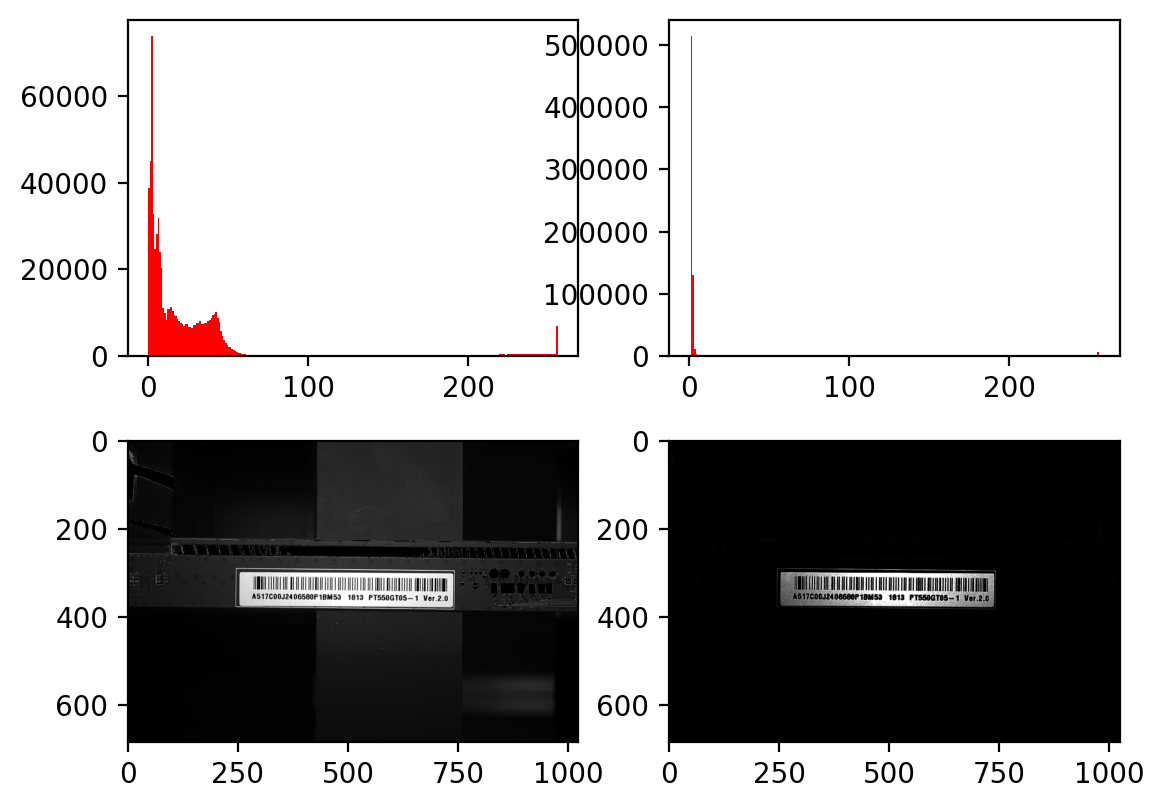

In [34]:
imax = np.max(image_gray)
image_equalized = (255 ** (image_gray / imax)).astype(np.uint8)
plt.figure(dpi=200)
plt.subplot(2, 2, 1)
plt.hist(image_gray.ravel(), 256, [0, 256], color='r')
plt.subplot(2, 2, 2)
plt.hist(image_equalized.ravel(), 256, [0, 256], color='r')

plt.subplot(2, 2, 3)
plt.imshow(image_gray, 'gray')
plt.subplot(2, 2, 4)
plt.imshow(image_equalized, 'gray')
plt.show()

# 条码区域定位

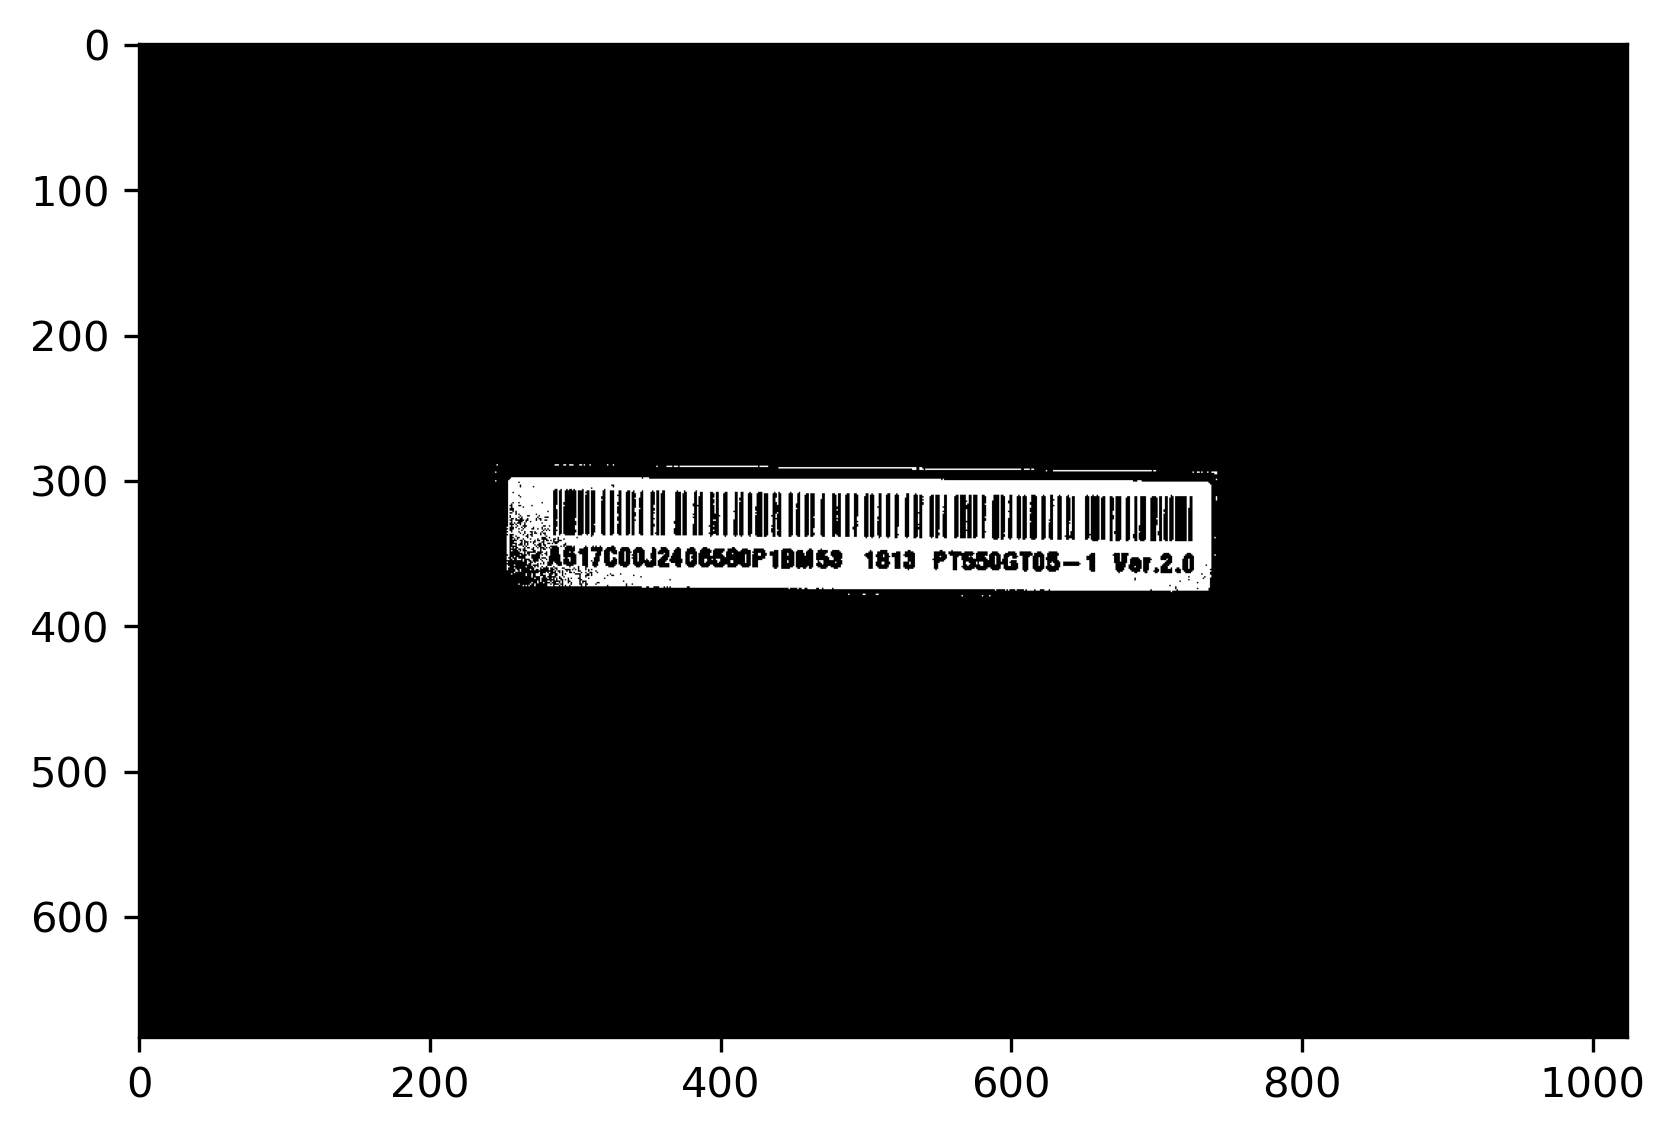

In [35]:
r, t = cv2.threshold(image_equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(dpi=300)
plt.imshow(t, 'gray')
plt.show()

In [ ]:
kernel = np.ones((3, 3), np.uint8)
# closing = cv2.morphologyEx(t, cv2.MORPH_OPEN, kernel)  #闭运算
closing = cv2.morphologyEx(t, cv2.MORPH_CLOSE, kernel)  #闭运算

contours1, hierarchy1 = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

lines_list2 = []
for contour2 in contours1:
	x, y, w, h = cv2.boundingRect(contour2)
	if cv2.contourArea(contour2) > area_threshold:

		image_gray_part = image_gray[y:y + h, x:x + w]

		ret2, image_threshold2 = cv2.threshold(image_gray_part, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

		# detect lines_list
		lines, width, prec, nfa = lsd.detect(image_threshold2)
		if lines is not None:
			if lines.shape[0] < 70:
				cv2.drawContours(image_gray, [contour2], -1, 0, cv2.FILLED)
			else:
				# for line in lines:
				# 	# 获取线段的起点和终点坐标
				# 	x1, y1, x2, y2 = line[0].astype(int)
				# 	# 绘制线段
				# 	cv2.line(image_pydown_s, (x + x1, y + y1), (x + x2, y + y2), (0, 255, 0), 2)
				cv2.drawContours(image_pydown_s, [contour2], -1, (0, 255, 0, 1))
			lines_list2.append(lines)
	else:

		cv2.drawContours(image_gray, [contour2], -1, 0, cv2.FILLED)
plt.figure(dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2RGB))
plt.show()


Function find_barcode_by_cluster took 22.053ms to run


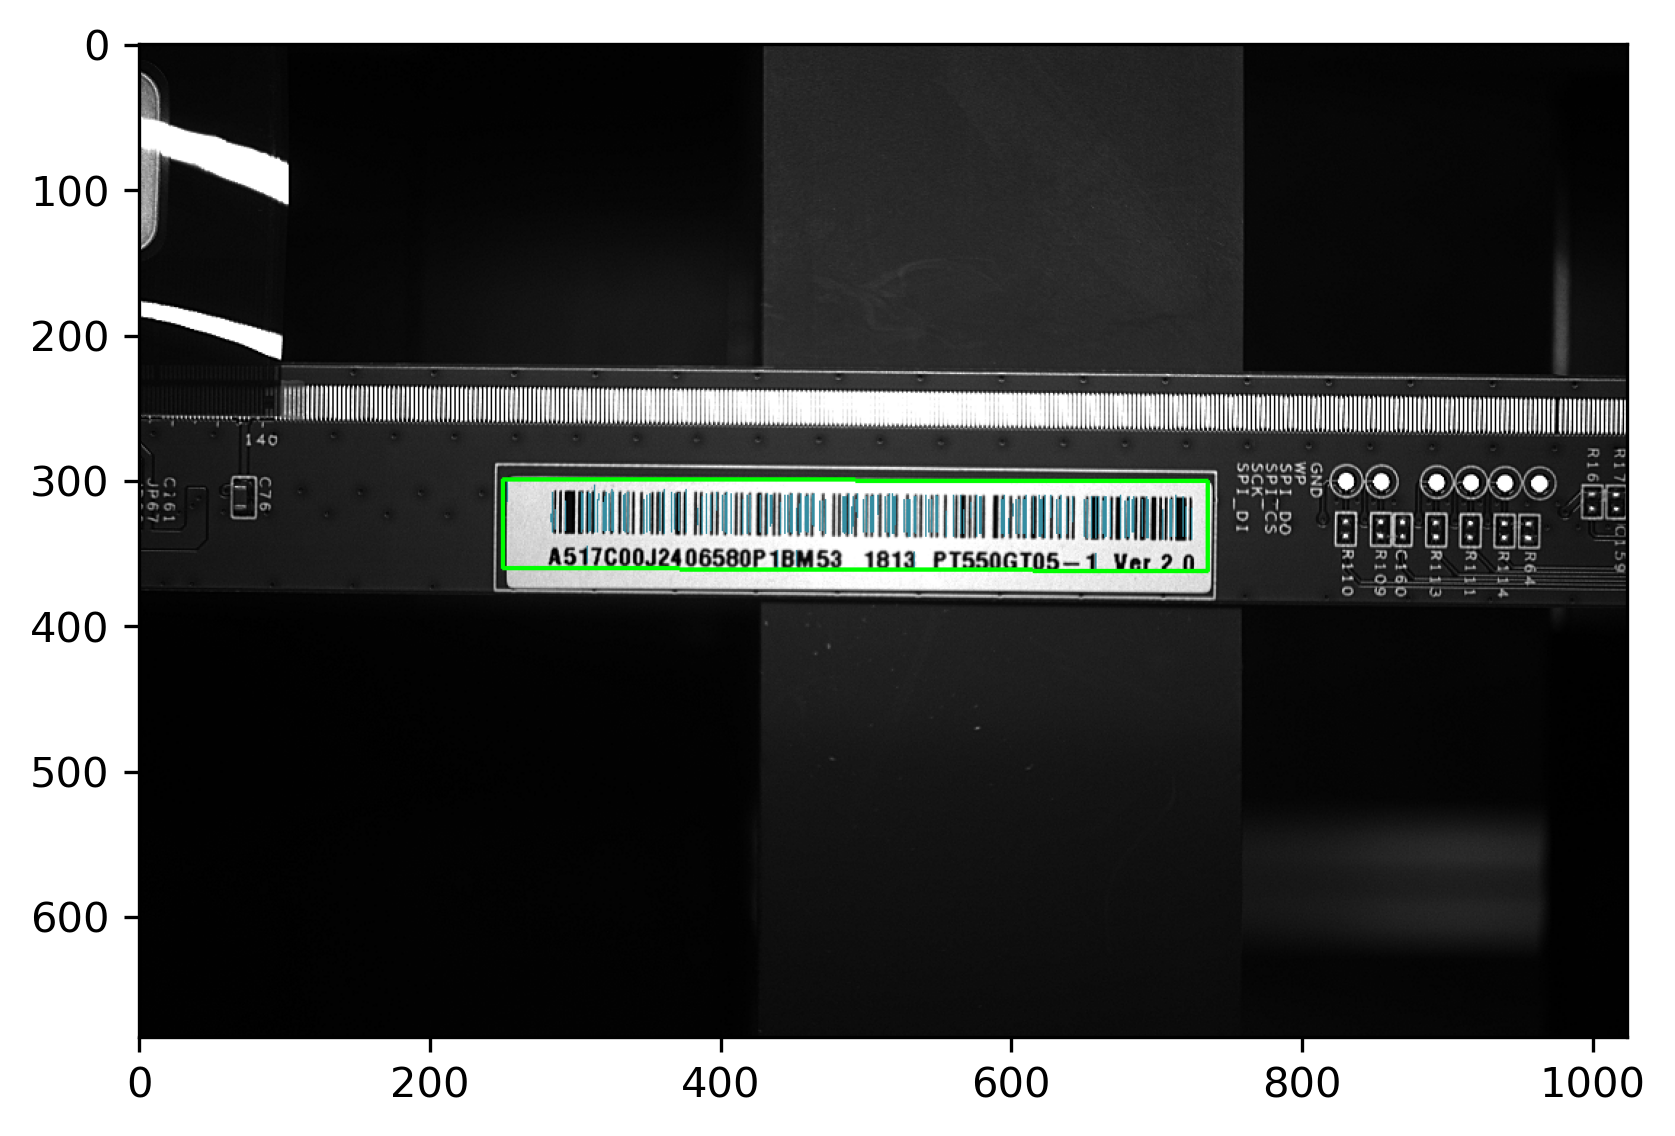

In [36]:
from LineCluster import find_barcode_by_cluster, draw_clusters, cluster_lines

clusters = find_barcode_by_cluster(t, 1)
image_drawed = draw_clusters(image_pydown_s, clusters)

plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_drawed, cv2.COLOR_BGR2RGB))
plt.show()


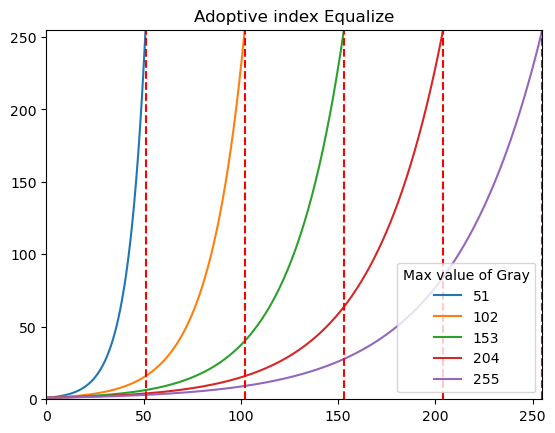

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 创建x取值范围
x1 = np.linspace(0, 51, 1000)
x2 = np.linspace(0, 102, 1000)
x3 = np.linspace(0, 153, 1000)
x4 = np.linspace(0, 204, 1000)
x5 = np.linspace(0, 255, 1000)

# 计算y的取值
y1 = np.power(255, x1 / 51)
y2 = np.power(255, x2 / 102)
y3 = np.power(255, x3 / 153)
y4 = np.power(255, x4 / 204)
y5 = np.power(255, x5 / 255)

# 绘制图像
plt.plot(x1, y1, label='51')
plt.plot(x2, y2, label='102')
plt.plot(x3, y3, label='153')
plt.plot(x4, y4, label='204')
plt.plot(x5, y5, label='255')

# 设置图例和标题
legend = plt.legend(loc='lower right')
legend.set_title('Max value of Gray')
plt.title('Adoptive index Equalize')
plt.xlim([0, 255])
plt.ylim([0, 255])
# 添加纵向网格线
for i in range(51, 256, 51):
	plt.axvline(x=i, color='red', linestyle='--')
# 显示图像
plt.show()
